In [1]:
from fastbook import *
from fastai.vision.widgets import *
from io import BytesIO
from PIL import Image
import pandas as pd
import requests

/home/henry/.local/share/mamba/envs/movieai/lib/python3.10/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
# Load CSV into DataFrame
movie_df = pd.read_csv("MovieGenre.csv", encoding='latin').dropna(subset=['Poster', 'Genre'])
movie_df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [3]:
# 1. Get list of frequent genres
genre_counts = movie_df['Genre'].str.split('|').explode().value_counts()
frequent_genres = set(genre_counts[genre_counts >= 50].index)

# Function to clean the strings of rare genres
def filter_rare_genres(genre_str):
    if not isinstance(genre_str, str): 
        return None

    # Keep only the genres that are in our frequent list
    genres = [g for g in genre_str.split('|') if g in frequent_genres]

    # Return the cleaned string, or None if no frequent genres remain
    return '|'.join(genres) if genres else None

# Apply the cleaning function
movie_df['Genre'] = movie_df['Genre'].apply(filter_rare_genres)

# Drop any rows that now have no genres left
movie_df = movie_df.dropna(subset=['Genre'])

In [4]:
# Create subset of random movies per genre
balanced_list = []

for genre in frequent_genres:
    genre_subset_df = movie_df[movie_df['Genre'].str.contains(genre)]
    n = min(len(genre_subset_df), 200)
    balanced_list.append(genre_subset_df.sample(n=n, random_state=42))

movie_subset_df = pd.concat(balanced_list).drop_duplicates(subset=['imdbId'])
movie_subset_df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
26365,1667079,http://www.imdb.com/title/tt1667079,Food Stamped (2010),6.5,Documentary|News,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTk3NjMyNTQ4M15BMl5BanBnXkFtZTcwNzg0NzM1NQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
14880,1232207,http://www.imdb.com/title/tt1232207,Capitalism: A Love Story (2009),7.4,Documentary|Crime|News,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjExOTI1NDQ4Nl5BMl5BanBnXkFtZTcwOTcwOTIxMw@@._V1_UY268_CR1,0,182,268_AL_.jpg"
24357,3264024,http://www.imdb.com/title/tt3264024,The Case Against 8 (2014),7.3,Documentary|Biography|News,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTAzMzYwNzM2NDheQTJeQWpwZ15BbWU4MDQzNDAxMDEx._V1_UX182_CR0,0,182,268_AL_.jpg"
26465,1766189,http://www.imdb.com/title/tt1766189,Koran by Heart (2011),7.4,Documentary|News,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTM5NzgyODcxOV5BMl5BanBnXkFtZTgwNjkxNzI1MDE@._V1_UX182_CR0,0,182,268_AL_.jpg"
23085,2093109,http://www.imdb.com/title/tt2093109,Escape Fire: The Fight to Rescue American Healthcare (2012),7.3,Documentary|News,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTU4MDA1NDU1NV5BMl5BanBnXkFtZTcwMjYzNTYxOA@@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [5]:
# Loop through subset and download poster images
valid_rows = []
for i, row in movie_subset_df.iterrows():
    try:
        # Create path for image based on imdbId
        path = Path('data')/f"{row['imdbId']}.jpg"

        # If image isn't downloaded already, download it
        if not path.exists():
            resp = requests.get(row['Poster'], timeout=5)
            Image.open(BytesIO(resp.content)).convert('RGB').save(path)
        
        # Add row to list of valid rows
        valid_rows.append(row)
    except:
        continue

# Convert list to DataFrame
valid_sample_df = pd.DataFrame(valid_rows)

In [6]:
# Function for getting the poster image file based on its ID
def get_x(r): return Path('./data')/f"{r['imdbId']}.jpg"

# Function for getting list of genres for the poster
def get_y(r): return r['Genre'].split('|')

# Create a DataBlock for loading
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [7]:
# Create DataLoaders using the DataBlock and the validated sample DataFrame
dls = dblock.dataloaders(valid_sample_df)

# Create the CNN model and train it
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

# Fit the model
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.978895,0.701155,0.605336,00:17


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.795719,0.613182,0.674633,00:14
1,0.662539,0.423783,0.845094,00:19
2,0.526613,0.339546,0.886697,00:14
3,0.444042,0.334407,0.888278,00:18


In [8]:
# Manual Testing

# Grab the first 'test_n' rows from the original DataFrame that don't appear in the sampled DataFrame
x = 1
test_n = 10
test_posters = []
for i, row in movie_df.iterrows():
    if row['imdbId'] not in valid_sample_df['imdbId']:
        try:
            path = Path('data/test/')/f"{row['imdbId']}.jpg"
            if not path.exists():
                resp = requests.get(row['Poster'], timeout=5)
                Image.open(BytesIO(resp.content)).convert('RGB').save(path)
                print(f"ID: {row['imdbId']} -- Title: {row['Title']} -- Genres: {row['Genre']}")
                
                # Add path to list
                test_posters.append([row['Title'], path])

                # Loop until 'test_n' num rows are found
                if x == test_n:
                    break
                else:
                    x += 1
                    continue
        except:
            continue




ID: 110932 -- Title: Quiz Show (1994) -- Genres: Biography|Drama|History
ID: 114129 -- Title: Picture Bride (1994) -- Genres: Drama|Romance
ID: 110963 -- Title: Queen Margot (1994) -- Genres: Biography|Crime|Drama
ID: 114214 -- Title: The Quick and the Dead (1995) -- Genres: Action|Romance|Thriller
ID: 114296 -- Title: Roommates (1995) -- Genres: Comedy|Drama
ID: 110907 -- Title: Ready to Wear (1994) -- Genres: Comedy|Drama
ID: 111495 -- Title: Three Colors: Red (1994) -- Genres: Drama|Mystery|Romance
ID: 110769 -- Title: Pao Da Shuang Deng (1994) -- Genres: Drama|Romance
ID: 114268 -- Title: Rent-a-Kid (1995) -- Genres: Drama|Family|Comedy
ID: 110965 -- Title: Relative Fear (1994) -- Genres: Drama|Horror|Thriller


Title: Quiz Show (1994)
Top 3 Genres: ['Thriller', 'Drama', 'Music']
Confidences: [0.6016078591346741, 0.5763987898826599, 0.4743620455265045]


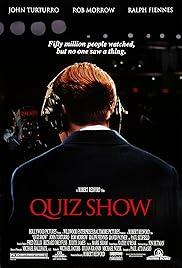

Title: Picture Bride (1994)
Top 3 Genres: ['Drama', 'Romance', 'Mystery']
Confidences: [0.4296219050884247, 0.2316657155752182, 0.21204610168933868]


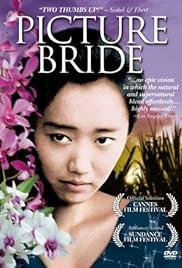

Title: Queen Margot (1994)
Top 3 Genres: ['Drama', 'Biography', 'Horror']
Confidences: [0.8771690726280212, 0.43099838495254517, 0.3416084349155426]


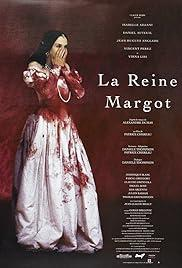

Title: The Quick and the Dead (1995)
Top 3 Genres: ['Drama', 'Thriller', 'Action']
Confidences: [0.7859181761741638, 0.6640588641166687, 0.5021222233772278]


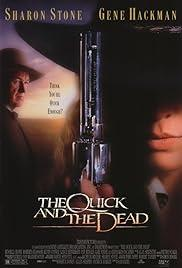

Title: Roommates (1995)
Top 3 Genres: ['Drama', 'Comedy', 'Adventure']
Confidences: [0.9057096242904663, 0.6781736612319946, 0.355787456035614]


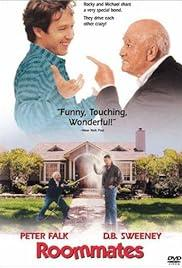

Title: Ready to Wear (1994)
Top 3 Genres: ['Drama', 'Comedy', 'Romance']
Confidences: [0.4859393537044525, 0.43900325894355774, 0.2539377212524414]


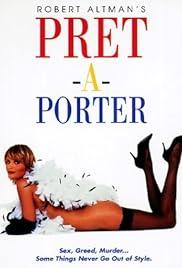

Title: Three Colors: Red (1994)
Top 3 Genres: ['Drama', 'Thriller', 'Mystery']
Confidences: [0.619751513004303, 0.48345300555229187, 0.28835591673851013]


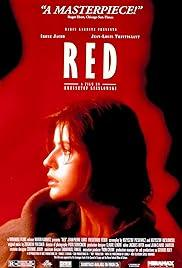

Title: Pao Da Shuang Deng (1994)
Top 3 Genres: ['Adventure', 'Family', 'Fantasy']
Confidences: [0.33561500906944275, 0.3333247900009155, 0.31733641028404236]


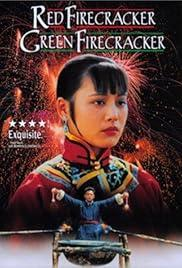

Title: Rent-a-Kid (1995)
Top 3 Genres: ['Comedy', 'Family', 'Sport']
Confidences: [0.8299735188484192, 0.5667378902435303, 0.40021243691444397]


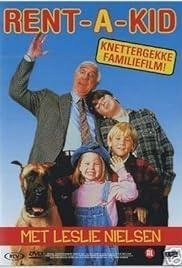

Title: Relative Fear (1994)
Top 3 Genres: ['Drama', 'Thriller', 'Horror']
Confidences: [0.8087998032569885, 0.3938889503479004, 0.3220135271549225]


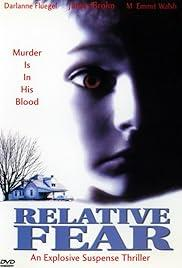

In [9]:
from IPython.display import display

for p in test_posters:

    # Get the raw probability tensor from the model
    pred_class, pred_idxs, probs = learn.predict(p[1])

    # Get the top 3 probablities and their indices
    top_probs, top_idxs = probs.topk(3)

    # Map the indices back to genre names
    top_genres = [learn.dls.vocab[i] for i in top_idxs]

    print(f"Title: {p[0]}")
    print(f"Top 3 Genres: {top_genres}")
    print(f"Confidences: {top_probs.tolist()}")
    display(Image.open(p[1]))